In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径

from itertools import chain


In [2]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\论文数据.xlsx'
df_sheet = pd.read_excel(excel_path)
# excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据\\数据-时间戳.xlsx'
# df_sheet = pd.read_excel(excel_path, sheet_name='Sheet4') 
# print(df_sheet.info())
print(df_sheet.columns)


Index(['主参数时间戳', '热风压力', '热风温度', '富氧率', '喷煤量', 'Unnamed: 5', '鼓风湿度',
       'Unnamed: 7', '炉腹煤气量', 'si'],
      dtype='object')


In [4]:
# 定义输入输出参数
input_term = ['热风压力', '热风温度', '富氧率', '喷煤量', '鼓风湿度', '炉腹煤气量']
output_term = ['si']
time_term= '主参数时间戳'


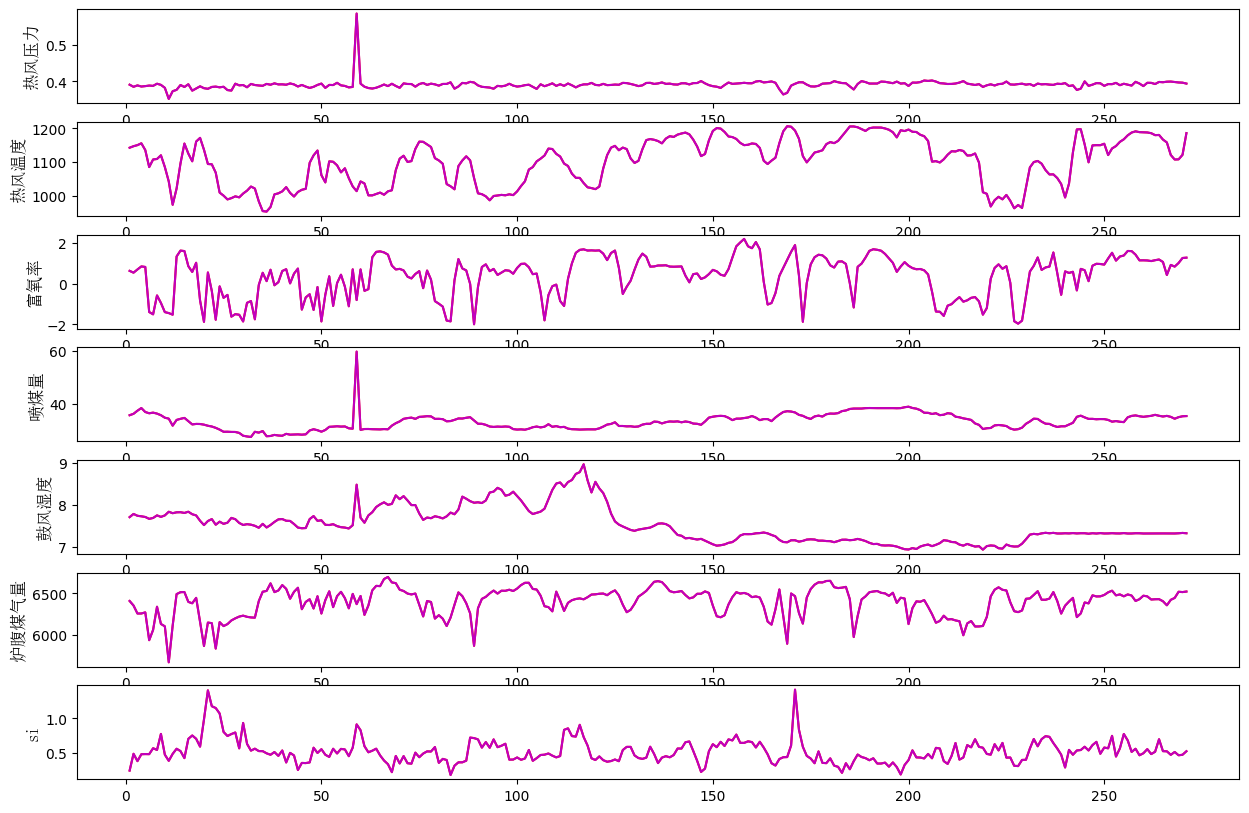

In [19]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 2.56 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value




# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
# replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[0]])
# replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[1]])
# replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[2]])
# replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[3]])
# replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[4]])
# replace_outliers_with_weighted_diff(df_sheet_process['主参数时间戳'], df_sheet_process[input_term[5]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




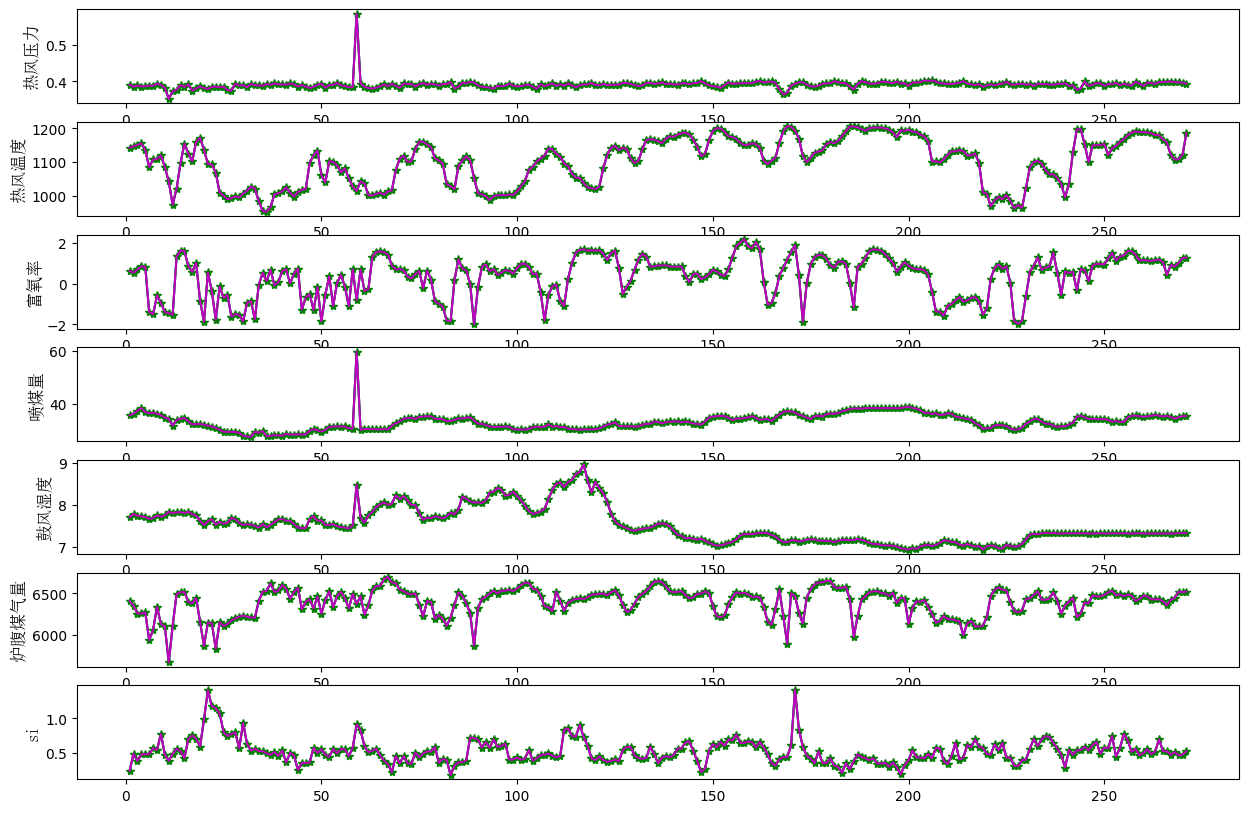

In [20]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'g*-')
    plt.plot(data_x[index_predict],data_y[index_predict],'m-')
    
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



# length1 = 300
# start1 = 430
# length2 = 300
# start2 = 230
# print((start2+length2-start1)/length2)
    


length2 = 270
start2 = 0
index_gaolu     = range(start2, start2+length2+1, 1)
index_predict   = index_gaolu
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [21]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_process[input_term[0]].values,
    input_term[1]:   df_sheet_process[input_term[1]].values,
    input_term[2]:   df_sheet_process[input_term[2]].values,
    input_term[3]:   df_sheet_process[input_term[3]].values,
    input_term[4]:   df_sheet_process[input_term[4]].values,
    input_term[5]:   df_sheet_process[input_term[5]].values,
    output_term[0]:  df_sheet_process[output_term[0]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [22]:
# 标定归一化前后数据
# data_point = np.array([1500]).reshape(-1, 1)
# data1 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# data_point = np.array([1510]).reshape(-1, 1)
# data3 = scalers[output_term[0]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# print('每摄氏度的输出差：',(data3-data1)/(data4-data2))



# data_point = np.array([0.5]).reshape(-1, 1)
# data1 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# data_point = np.array([0.6]).reshape(-1, 1)
# data3 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# print('每0.01浓度的输出差：',(data3-data1))


In [46]:
# 组合训练数据--拆分训练、测试集
test_size = 0.25
def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,y1_data,test_size):
    u1_data = u1_data
    u2_data = u2_data
    u3_data = u3_data
    u4_data = u4_data
    u5_data = u5_data
    u6_data = u6_data

    u1_data_1 = np.roll(u1_data, 1)
    u2_data_1 = np.roll(u2_data, 1)
    u3_data_1 = np.roll(u3_data, 1)
    u4_data_1 = np.roll(u4_data, 1)
    u5_data_1 = np.roll(u5_data, 1)
    u6_data_1 = np.roll(u6_data, 1)

    y1_data = y1_data

    X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1], u3_data  [1:-1], u4_data  [1:-1], u5_data  [1:-1], u6_data  [1:-1],
                            u1_data_1[1:-1], u2_data_1[1:-1], u3_data_1[1:-1], u4_data_1[1:-1], u5_data_1[1:-1], u6_data_1[1:-1]
                            ,y1_data  [1:-1]
                            )
                        )
    y = np.column_stack((y1_data[2:]))

    # 使用 reshape 转换形状(457, 10) (457, 2)--->(457, 1, 10) (457, 1, 2)
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    y_reshaped = y.reshape((y.shape[1], 1, y.shape[0]))
    print(y.shape)



    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        # shuffle=True)
                                                        shuffle=False)




    # # 计算划分点
    # split_point = int(len(X_reshaped) * (1 - test_size))
    # # 划分数据集
    # X_train, X_test = X_reshaped[:split_point], X_reshaped[split_point:]
    # y_train, y_test = y_reshaped[:split_point], y_reshaped[split_point:]

    # print(X_reshaped)
    # print('gggggggg')
    # print(X_train)
    # print(X_test)
    # print('gggggggg')
    # print(y_reshaped)
    # print('gggggggg')
    # print(y_train)
    # print(y_test)

    y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
    y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
    print(X_train.shape,y_train.shape)
    print(X_test.shape,y_test.shape)

    return X_train, X_test, y_train, y_test ,X_reshaped, y_reshaped


In [47]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
u5_data = normalized_data_dict[input_term[4]][index_gaolu]
u6_data = normalized_data_dict[input_term[5]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
num_samples = y1_data.shape[0]


# print('Oxygen_enrich_rate:', u1_data.shape)
# print('Set_coal_amount:', u2_data.shape)
# print('hot_wind_temp:', u3_data.shape)
# print('hot_wind_presure:', u4_data.shape)
# print('temp:', y1_data.shape)
# print('Si_percent:', y2_data.shape)
# print(num_samples)

X_gaolu_train, X_gaolu_test,\
y_gaolu_train, y_gaolu_test ,X_reshaped, y_reshaped = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,y1_data,
                                        test_size=test_size)



(1, 269)
(201, 1, 13) (201, 1)
(68, 1, 13) (68, 1)


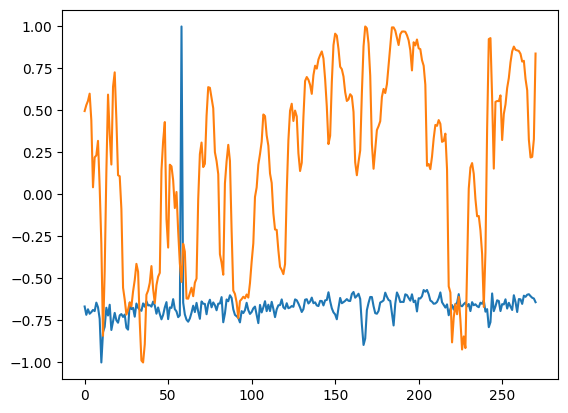

In [34]:
plt.plot(u1_data)
plt.plot(u2_data)
# plt.plot(u3_data)
# plt.plot(u4_data)
# plt.plot(y1_data)
# plt.plot(y2_data)


In [35]:
# 定义LSTM模型

import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,features_size,hidden_size,isbidirectional):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=features_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=isbidirectional
        )
        if isbidirectional:
            self.fc = nn.Linear(2 * hidden_size, 1)
        else:
            self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        
        return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse

    def my_fit(self, X_train, y_train, epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        loss_list = []

        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_loss = epoch_loss / (len(X_train) // batch_size + 1)
            print(f'第 {epoch + 1}/{epochs} 轮, 误差: {average_epoch_loss:.4f}', end='\r')
            loss_list.append(average_epoch_loss)

        return loss_list

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred.detach().numpy()


In [36]:
# 建立高炉模型实例
features_size = 13
hidden_size = 32
torch.manual_seed(0)
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=False)
epoch_sum_gaolu = 0


In [37]:
# 高炉模型训练
epoch_once = 200
epoch_sum_gaolu = epoch_sum_gaolu+epoch_once
loss_history = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train, epochs=epoch_once, batch_size=64,lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)


第 200/200 轮, 误差: 0.0253
epoch_sum: 200


RMSE: si: 0.0986
MRE : si: 0.1585
MAPE: si: 15.8495%
MAE:0.0807,RMSE:0.2842,HR:0.6765,RE:0.0458


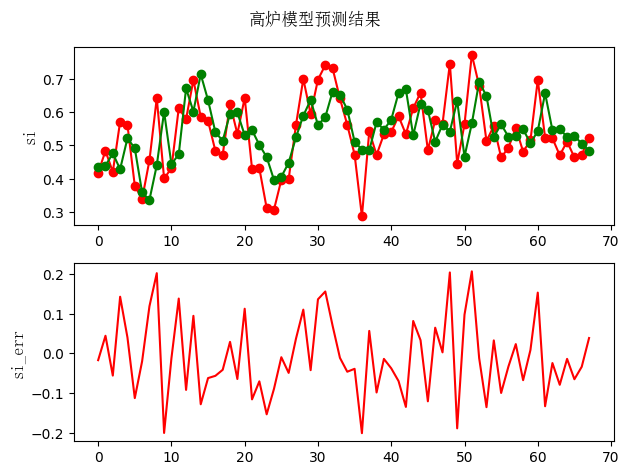

In [50]:
# 高炉模型预测
y_pred_0  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test

# y_test = y_test[:-1]
# y_pred_0 = y_pred_0[1:]

y_test_0 = scalers[output_term[0]].inverse_transform(y_test).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))

# 打印结果
print(f"RMSE: {output_term[0]}: {rmse_0:.4f}")
print(f"MRE : {output_term[0]}: { mre_0:.4f}")
mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
print(f"MAPE: {output_term[0]}: {mape_0:.4f}%")



output0 = y_test_0 - y_pred_0_inverse_transform
MAE = np.mean(np.abs(output0))
RMSE = np.sqrt(MAE)
HR = np.sum(np.abs(output0)<0.1)/len(output0)
RE = np.sum(output0**2)/np.sum(y_gaolu_test**2)
print(f'MAE:{MAE:.4f},RMSE:{RMSE:.4f},HR:{HR:.4f},RE:{RE:.4f}')

plt.subplot(2, 1, 1)
plt.plot(y_test_0,'ro-')
plt.plot(y_pred_0_inverse_transform,'go-')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签



plt.subplot(2, 1, 2)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签
plt.suptitle('高炉模型预测结果', fontproperties=font)  # 添加整个图形的标题
plt.tight_layout()
plt.show()



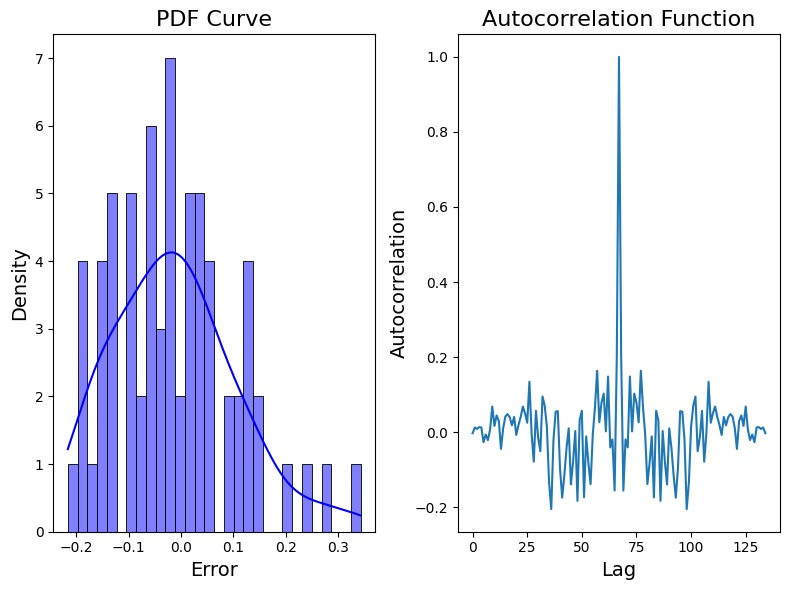

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 计算误差的概率密度函数曲线
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
sns.histplot(output0, kde=True, color="blue", bins=30)
plt.title("PDF Curve", fontsize=16)
plt.xlabel("Error", fontsize=14)
plt.ylabel("Density", fontsize=14)


# 计算误差的自相关函数曲线
plt.subplot(1,2,2)
autocorrelation = np.correlate(output0, output0, mode='full')
autocorrelation /= autocorrelation.max()
plt.plot(autocorrelation)
plt.title("Autocorrelation Function", fontsize=16)
plt.xlabel("Lag", fontsize=14)
plt.ylabel("Autocorrelation", fontsize=14)
plt.tight_layout()
plt.show()
